<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GAN_1D_same_amplitude_sinus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple GAN model for generating 1D functions**

## **Installing keras deep learning library**

In [3]:
!pip3 install scipy keras

## **Imports**

In [4]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.layers import LeakyReLU

# numpy
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint

# Basics of Python data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib import pyplot
from timeit import default_timer as timer
# import rasterio

Using TensorFlow backend.


## **Google drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **Demonstrate simple x^2 function**
generate samples, generate real samples


In [0]:
# demonstrate simple x^2 function
def calculate(x):
	return x * x

# generate randoms sample from x^2 - FUNKCIA

def generate_samples(n=100):
	X1 = rand(n) - 0.5
	#print(X1)
	X2 = X1 * X1
	# stack arrays - spojim dva stlpce X1 a X2
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))  #vystup je v returne, dalej ukladam do x2_data 

# generate n REAL samples with class labels

def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1)) # tymto hovorim ze vsetky vygenerovane data su real, same jednotky
	return X, y

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
print('vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)')
pyplot.plot(inputs, outputs)
pyplot.title('Mocninová funkcia x^2')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.show()

# generate samples
x2_data = generate_samples(50)
print('Random Real samples od -0,5 do 0,5') 
# plot samples
pyplot.scatter(x2_data[:, 0], x2_data[:, 1])
pyplot.title('Reálne náhodne vybraté body')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.show()

## **Define a Discriminator model**
diskrimator_model, loss, optimization, metrics

**Inputs:** Sample with two real values. (vstup1 : vstupny stlpec,vstup2: vystupny stlpec)

**Outputs:** Binary classification, likelihood the sample is real (or fake). 0/1

In [0]:
def define_discriminator(n_inputs=2):
	discriminator_model = Sequential() #The Sequential model is a linear stack of layers.
	# dense=2D layer, musi poznat imput - zadavam cez inputshape, imput dim - atd vid link
	discriminator_model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))  
	discriminator_model.add(Dense(1, activation='sigmoid'))
 

# definujeme loss funkciu,   optimalizer-sposob ucenia     metrics - hodnoti vykon,spravnost modelu = metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model. You may use any of the loss functions as a metric function.
# https://keras.io/losses/    https://keras.io/optimizers/    https://keras.io/metrics/

	# compile model
	discriminator_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return discriminator_model


# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)



## **Define a Generator Model**
generator model, latent points

Predict generatoru z latent points, 5 dimenzii,50 hodnot


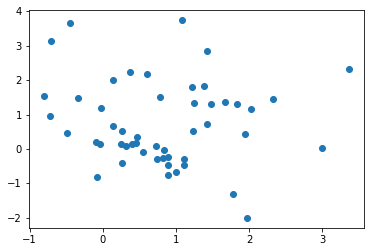

Model summary
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 15)                90        
_________________________________________________________________
dense_104 (Dense)            (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
Model plot


(0.0, 30.0)

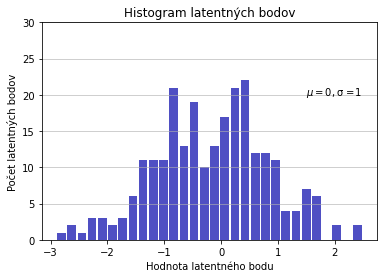

In [0]:
def define_generator(latent_dim, n_outputs=2):
	generator_model = Sequential()
	generator_model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) 
	generator_model.add(Dense(n_outputs, activation='linear'))
	return generator_model

#The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n) 
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# size of the latent space
latent_dim = 5
# define the generator model
generator_model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(generator_model, latent_dim, 50)

# summarize the model
print('Model summary')
generator_model.summary()
# plot the model
print('Model plot')
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

latent_std=1
latent_mean=0
latent_points=generate_latent_points(5,50)
latent_points=latent_points.reshape(250)
n, bins, patches = plt.hist(x=latent_points, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hodnota latentného bodu')
plt.ylabel('Počet latentných bodov')
plt.title('Histogram latentných bodov')
plt.text(1.5, 20, r'$\mu =0, $σ =1')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


## **Define GAN**

The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

**The generator model is only concerned with the discriminator’s performance on fake examples.**
Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. 
Therefore, **when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).**

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this 
as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

**Inputs:** Point in latent space, e.g. a five-element vector of Gaussian random numbers.

**Outputs:** Binary classification, likelihood the sample is real (or fake).


Gan model summary :
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_56 (Sequential)   (None, 2)                 122       
_________________________________________________________________
sequential_57 (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________
Gan model plot: 


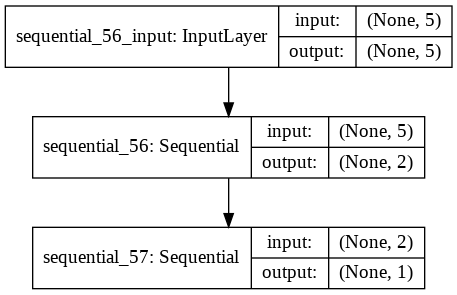

In [0]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator_model, discriminator_model):
	# make weights in the discriminator not trainable
	discriminator_model.trainable = False
	# connect them
	gan_model = Sequential()
	# add generator
	gan_model.add(generator_model)
	# add the discriminator
	gan_model.add(discriminator_model)
	# compile model
	gan_model.compile(loss='binary_crossentropy', optimizer='adam')
	return gan_model

# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


## **Final GAN Model** 
generating x^2 function

In [0]:
# DENSE VRSTVA 
# Just your regular densely-connected NN layer. (https://keras.io/layers/core/)
# Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# define the standalone DISCRIMINATOR model

# vstup 2 vektory 1D hodnot- vstup1[x,x^2], vstup2[label]
# vystup 25 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 25 (vystup z predchadzajucej)
# 1 neuron vystupna vrstva 
# AKTIVACNA FUNKCIA : sigmoid (0-1)

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam
# METRICS : accuracy

start = timer()

def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# define the standalone GENERATOR model

# vstup su hodnoty (5) z latent space - 5 dimenzii = 5hodnot, dimenziu viem nastavit (five-element vector of Gaussian random numbers)
# 15 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 15 (vystup z predchadzajucej)
# vystup 2 hodnoty x a y(x na druhu),
# AKTIVACNA FUNKCIA : linear
# Linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5 -x axes] 
# for the first element and about [0.0, 0.25 -y xes] for the second element.


def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam

# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate n real samples with class labels

def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space - 5x100 hodnot = 500 hodnot gaussovsky rozlozenych 
	# -> We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.title('Iterácia :'+ "  " + str(epoch+1)+" | "+'acc_real ='+"  "+str(np.round(acc_real,4))+" | "+'acc_fake ='+"  "+str(np.round(acc_fake,4)))
	pyplot.show()
	if (acc_fake > 0.475) and (acc_fake < 0.525) and (acc_real > 0.475) and (acc_real < 0.525) and epoch>50000:
		print('Model is trained')
		a=1/0

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# batch size - staci do 512
# epochy - kolko treba
# n_eval - po kolkych epochach vyhodnocovat

def train(generator_model, discriminator_model, gan_model, latent_dim, n_epochs=100000, n_batch=512,n_eval=500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch) # generator model instead of random numbers
		# update discriminator
		d_real_loss,d_real_acc=discriminator_model.train_on_batch(x_real, y_real)
		d_fake_loss,d_fake_acc=discriminator_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		g_loss=gan_model.train_on_batch(x_gan, y_gan)
		d_real_loss_graph.append(d_real_loss)
		d_real_acc_graph.append(d_real_acc)
		d_fake_loss_graph.append(d_fake_loss)
		d_fake_acc_graph.append(d_fake_acc)
		g_loss_graph.append(g_loss)
  # evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
		  summarize_performance(i, generator_model, discriminator_model, latent_dim)
	 
					
d_real_loss_graph=[]
d_real_acc_graph=[]
d_fake_loss_graph=[]
d_fake_acc_graph=[]
g_loss_graph=[]
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

end = timer()
print(end - start)

(59,)

### Plotting losses and accuracies
x^2

In [0]:
filtered_list_real = [ item for i,item in enumerate(d_real_acc_graph) if i%100==0 ]
filtered_list_fake = [ item for i,item in enumerate(d_fake_acc_graph) if i%100==0 ]

time_axis=np.linspace(0,53000,530)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť na reálnych bodoch', 'x': time_axis, 'y': filtered_list_real[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť na falošných bodoch', 'x': time_axis, 'y': filtered_list_fake[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Presnosť',fontsize=20)

time_axis=np.linspace(0,53000,53000)
d_loss_total= np.array(d_real_loss_graph)+np.array(d_fake_loss_graph)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': d_loss_total[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': g_loss_graph[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Hodnota chyby',fontsize=20)



## **Final GAN Model2**
generating sine function

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


2499 0.49000000953674316 0.5


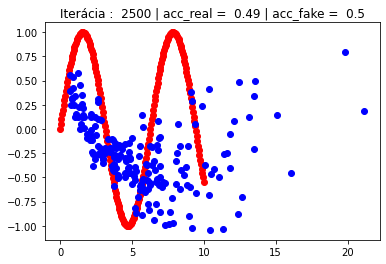

4999 0.41499999165534973 0.8199999928474426


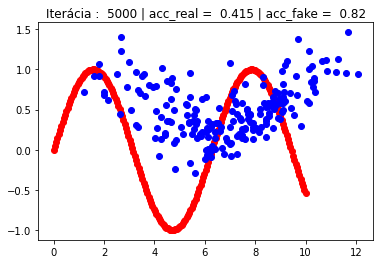

7499 0.5099999904632568 0.9049999713897705


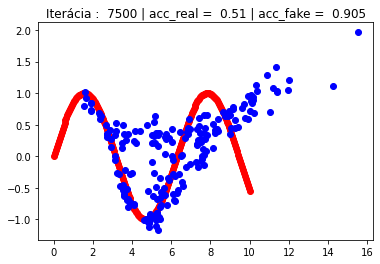

9999 0.375 0.9399999976158142


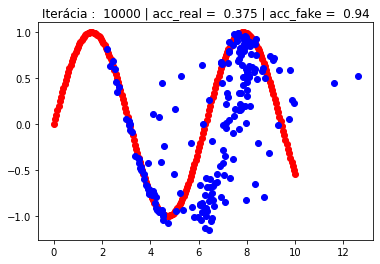

12499 0.4950000047683716 0.8600000143051147


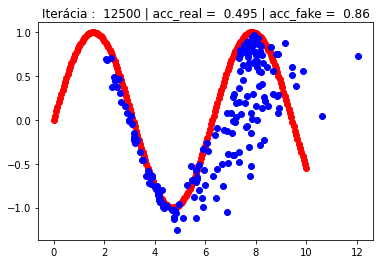

14999 0.4699999988079071 0.8100000023841858


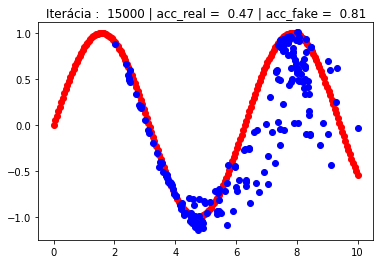

17499 0.36000001430511475 0.8849999904632568


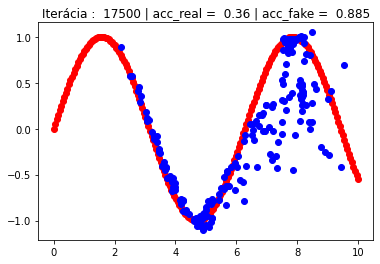

19999 0.44999998807907104 0.9549999833106995


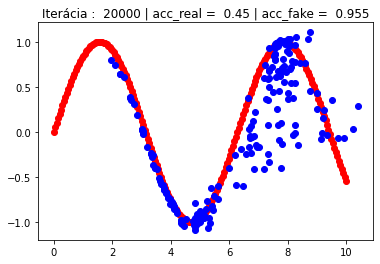

22499 0.44999998807907104 0.8550000190734863


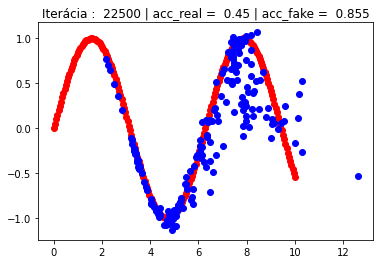

24999 0.41999998688697815 0.8849999904632568


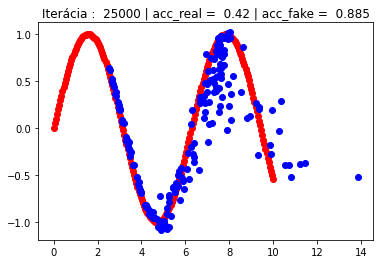

27499 0.3199999928474426 0.9300000071525574


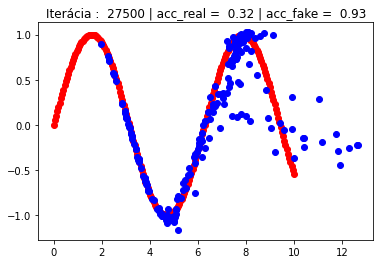

29999 0.4350000023841858 0.9599999785423279


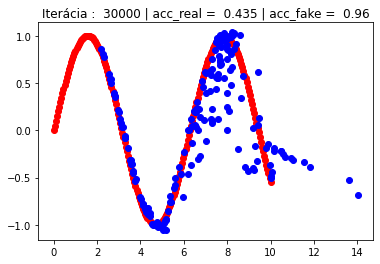

32499 0.3100000023841858 0.9449999928474426


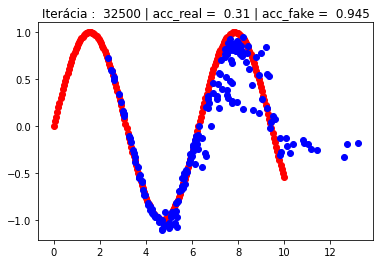

34999 0.44999998807907104 0.9950000047683716


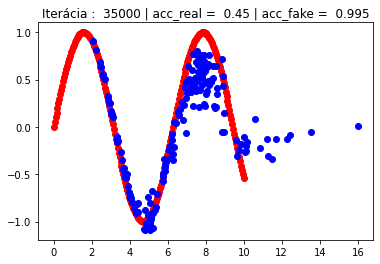

37499 0.42500001192092896 0.8100000023841858


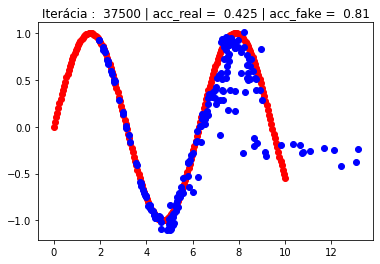

39999 0.3700000047683716 0.9800000190734863


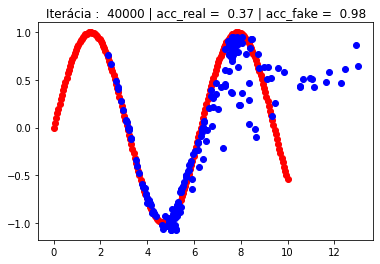

42499 0.4300000071525574 0.9100000262260437


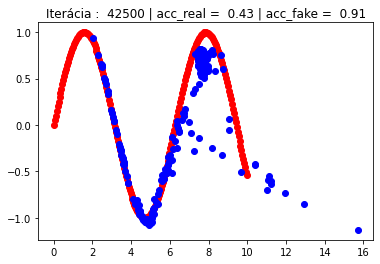

44999 0.3799999952316284 0.9800000190734863


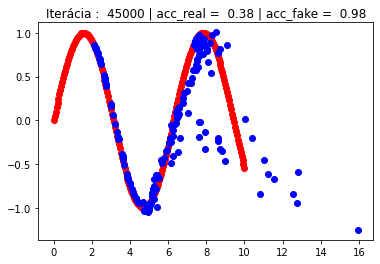

47499 0.44999998807907104 0.8050000071525574


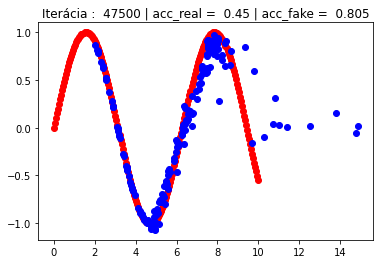

49999 0.4350000023841858 0.9750000238418579


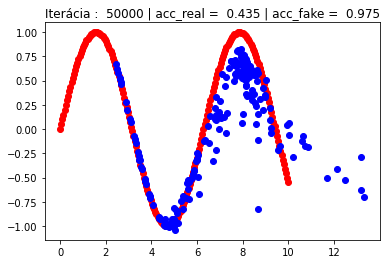

52499 0.45500001311302185 0.8100000023841858


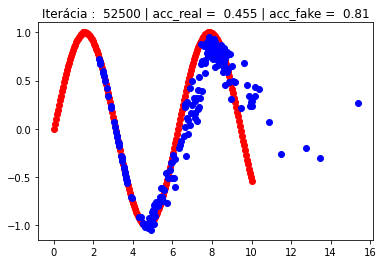

54999 0.45500001311302185 0.9549999833106995


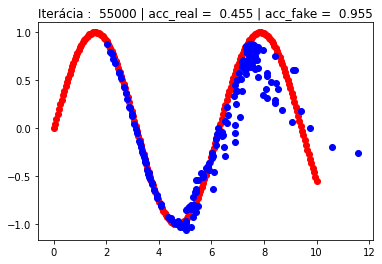

57499 0.44999998807907104 0.8500000238418579


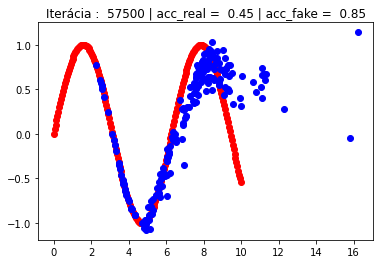

59999 0.45500001311302185 0.9599999785423279


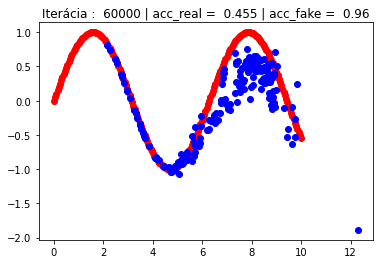

62499 0.45500001311302185 0.8399999737739563


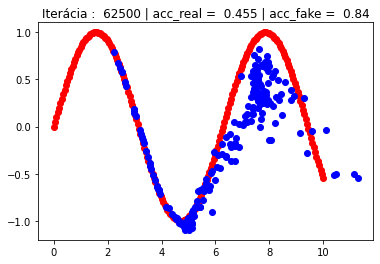

64999 0.44999998807907104 0.8550000190734863


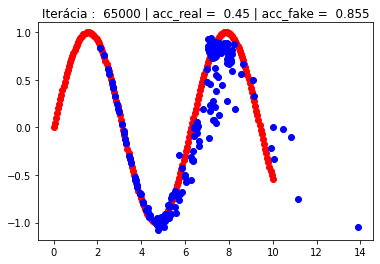

67499 0.4650000035762787 0.9200000166893005


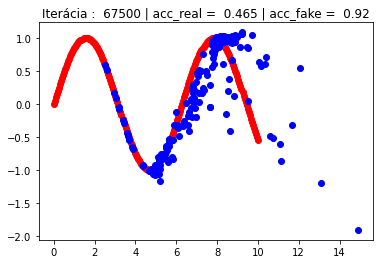

69999 0.39500001072883606 0.9649999737739563


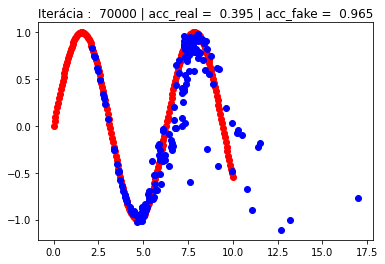

72499 0.4749999940395355 0.8799999952316284


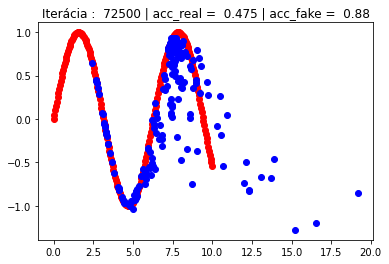

74999 0.47999998927116394 0.8999999761581421


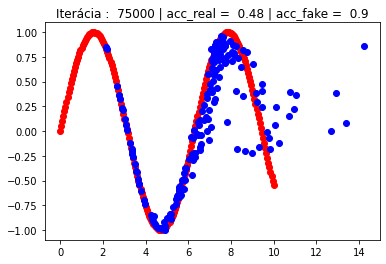

77499 0.4749999940395355 0.9100000262260437


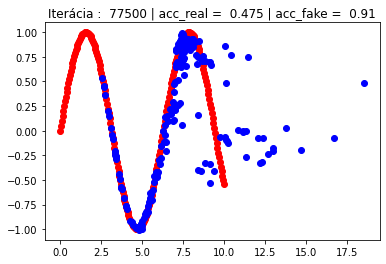

79999 0.5149999856948853 0.8450000286102295


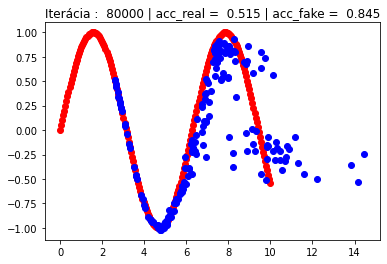

82499 0.5400000214576721 0.8949999809265137


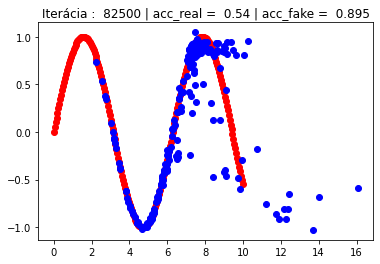

84999 0.4449999928474426 0.949999988079071


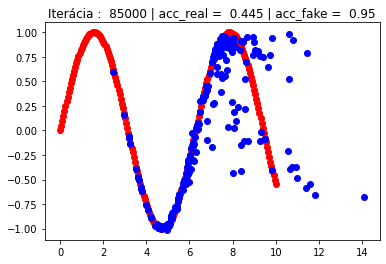

87499 0.4699999988079071 0.9900000095367432


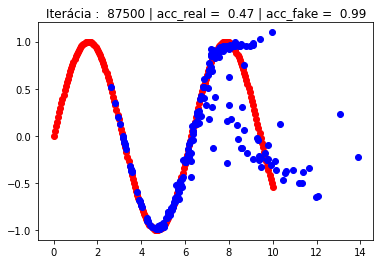

89999 0.5299999713897705 0.8849999904632568


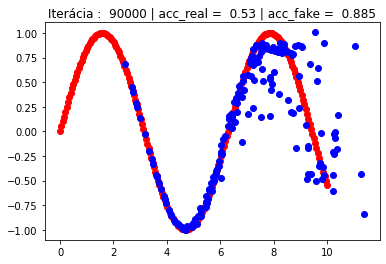

92499 0.4699999988079071 0.8849999904632568


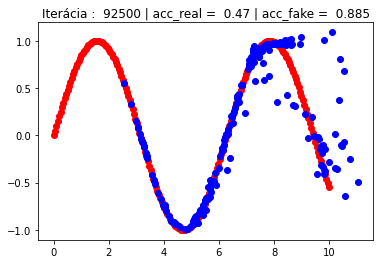

94999 0.5 0.8799999952316284


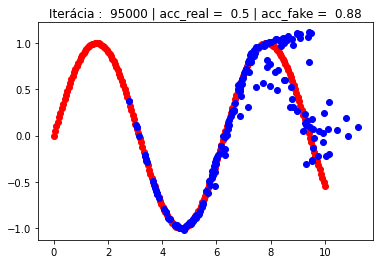

97499 0.44999998807907104 0.8199999928474426


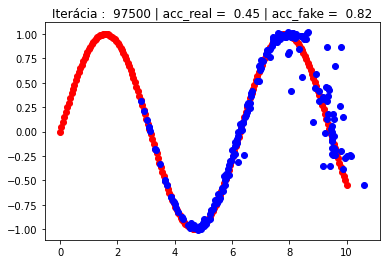

99999 0.5 0.875


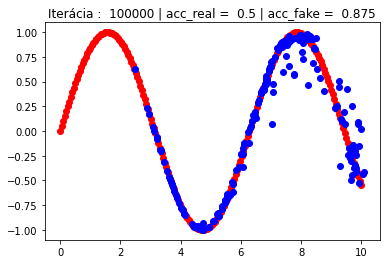

102499 0.5 0.8500000238418579


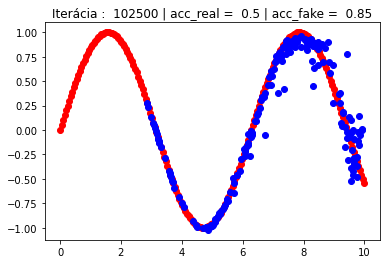

104999 0.4950000047683716 0.9150000214576721


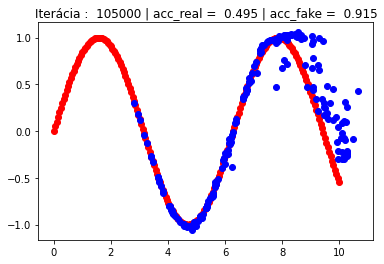

107499 0.5199999809265137 0.8949999809265137


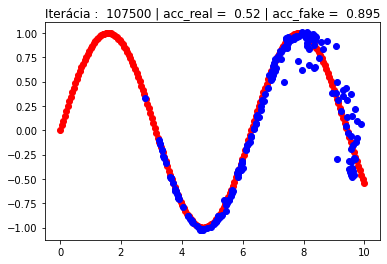

109999 0.5400000214576721 0.8149999976158142


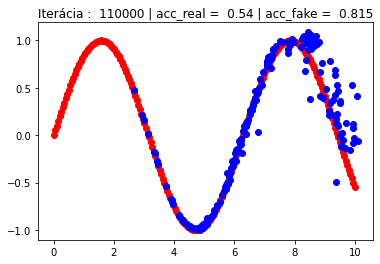

112499 0.5400000214576721 0.9300000071525574


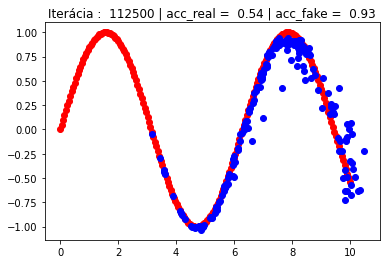

114999 0.6549999713897705 0.8100000023841858


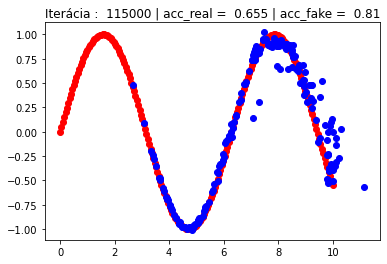

117499 0.46000000834465027 0.8600000143051147


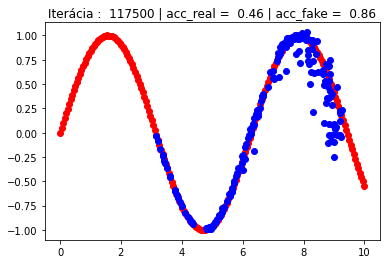

119999 0.5299999713897705 0.8600000143051147


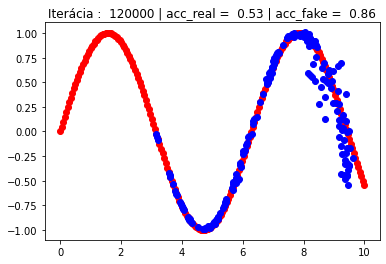

122499 0.5849999785423279 0.7450000047683716


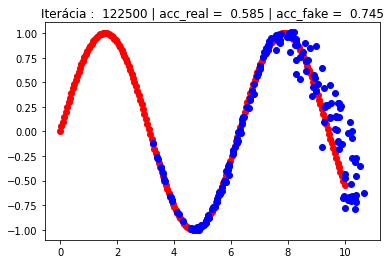

124999 0.5199999809265137 0.9300000071525574


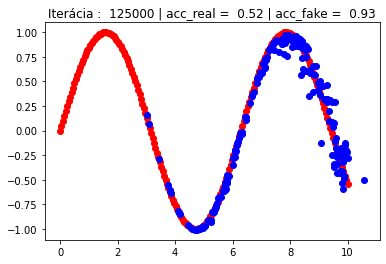

127499 0.5149999856948853 0.9649999737739563


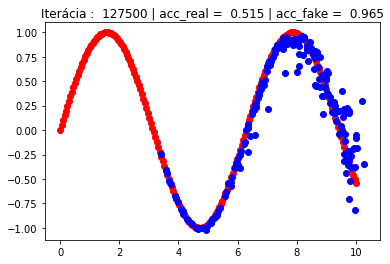

129999 0.550000011920929 0.7799999713897705


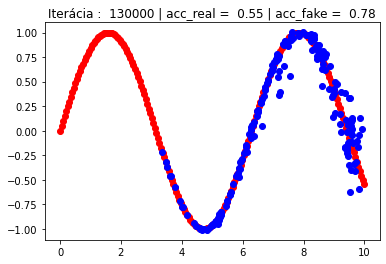

132499 0.625 0.8650000095367432


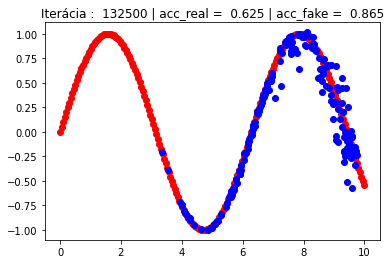

134999 0.4950000047683716 0.875


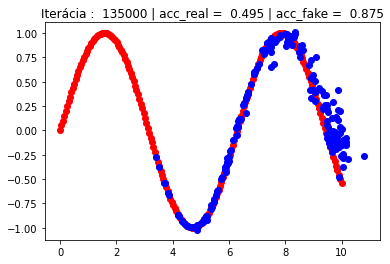

137499 0.5400000214576721 0.8949999809265137


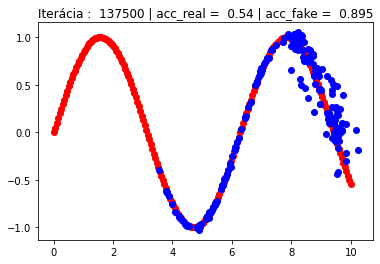

139999 0.5249999761581421 0.9100000262260437


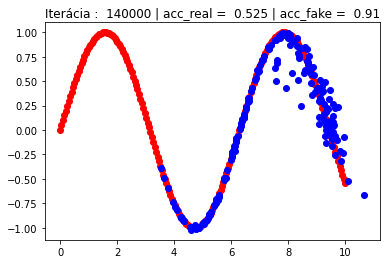

142499 0.5249999761581421 0.8949999809265137


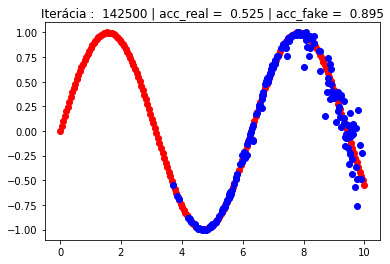

144999 0.5799999833106995 0.8999999761581421


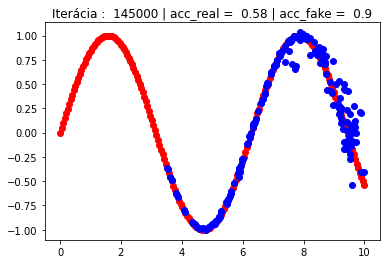

147499 0.6650000214576721 0.7850000262260437


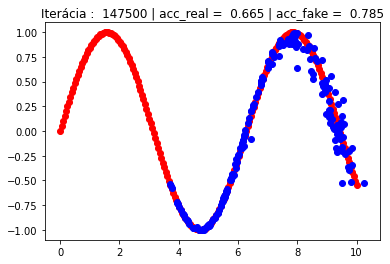

149999 0.5299999713897705 0.8949999809265137


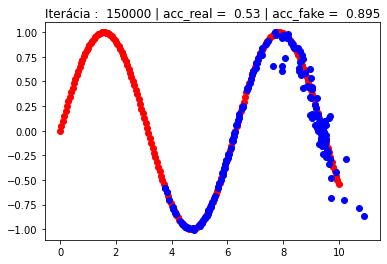

152499 0.5550000071525574 0.8949999809265137


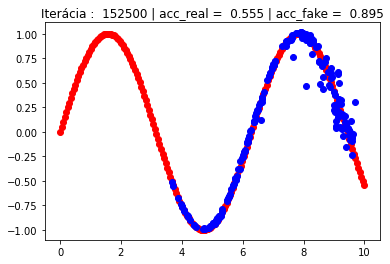

154999 0.5649999976158142 0.9350000023841858


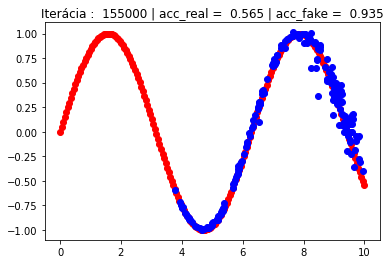

157499 0.6399999856948853 0.8149999976158142


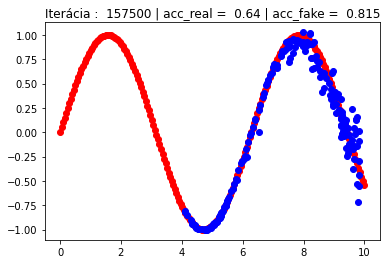

159999 0.6349999904632568 0.6800000071525574


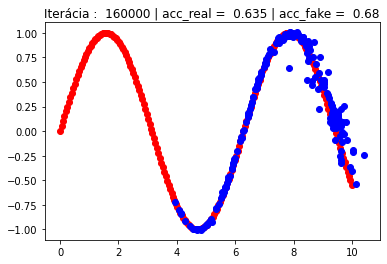

162499 0.5550000071525574 0.7799999713897705


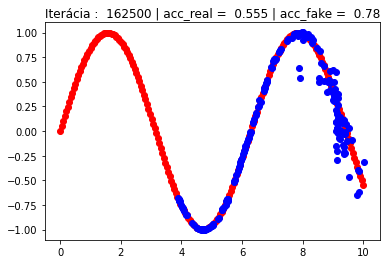

164999 0.7649999856948853 0.7250000238418579


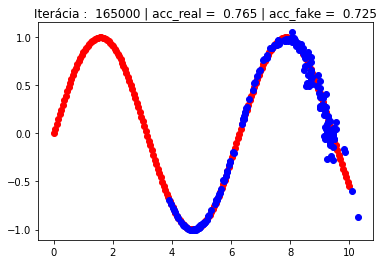

167499 0.7599999904632568 0.875


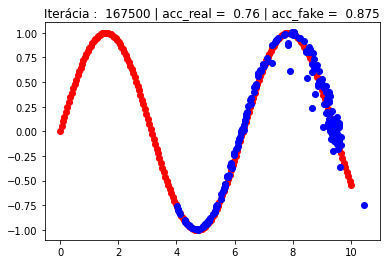

169999 0.5049999952316284 0.9300000071525574


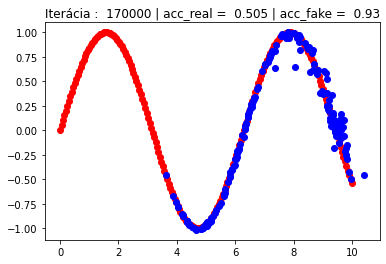

172499 0.6949999928474426 0.7900000214576721


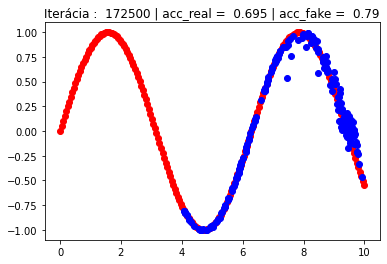

174999 0.5950000286102295 0.8550000190734863


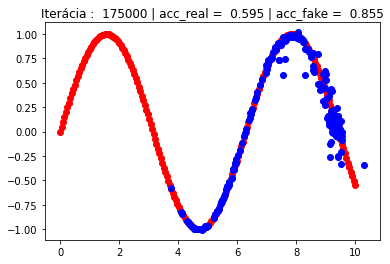

177499 0.6100000143051147 0.7699999809265137


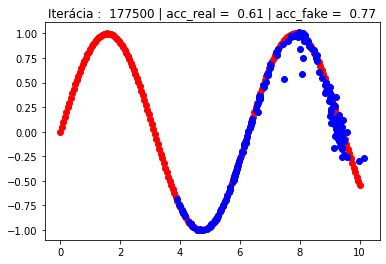

179999 0.574999988079071 0.9300000071525574


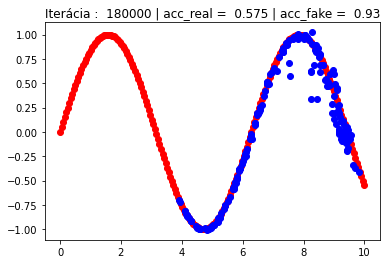

182499 0.7099999785423279 0.824999988079071


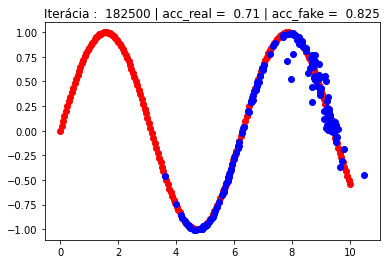

184999 0.6549999713897705 0.875


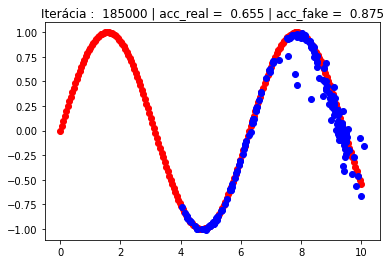

187499 0.6499999761581421 0.9150000214576721


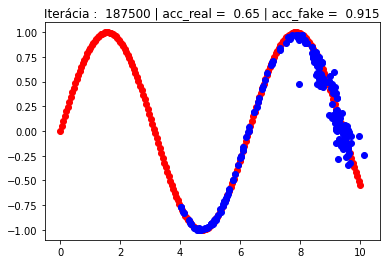

189999 0.7049999833106995 0.7850000262260437


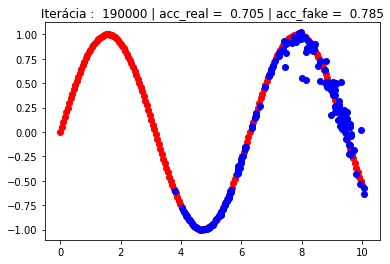

192499 0.6299999952316284 0.8700000047683716


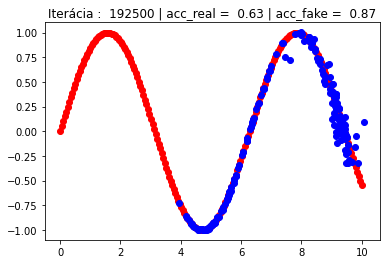

194999 0.6549999713897705 0.824999988079071


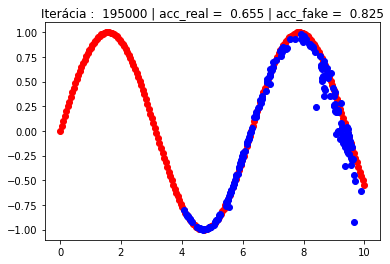

197499 0.5550000071525574 0.8799999952316284


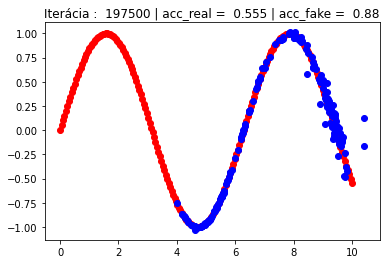

199999 0.6399999856948853 0.8899999856948853


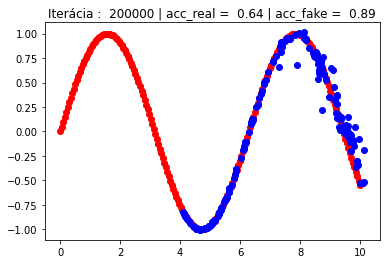

202499 0.574999988079071 0.9200000166893005


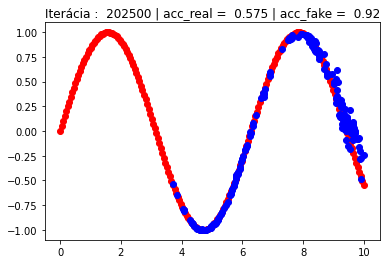

204999 0.7250000238418579 0.7900000214576721


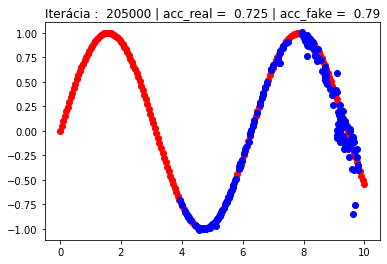

207499 0.8050000071525574 0.8849999904632568


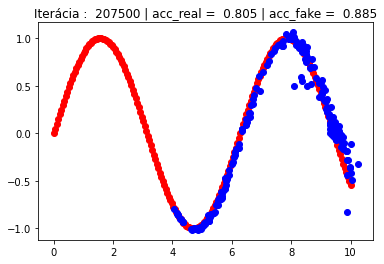

209999 0.574999988079071 0.875


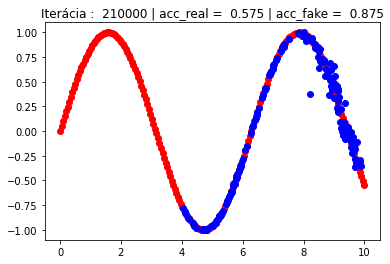

212499 0.6800000071525574 0.9549999833106995


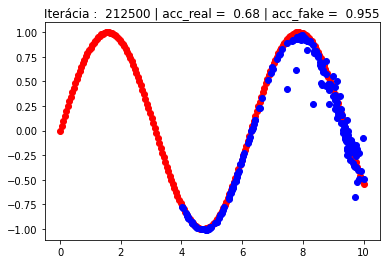

214999 0.5899999737739563 0.8149999976158142


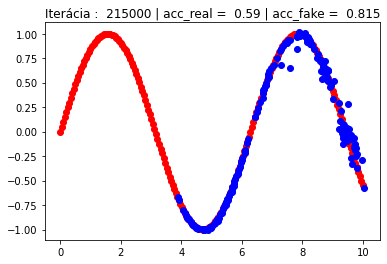

217499 0.7350000143051147 0.7599999904632568


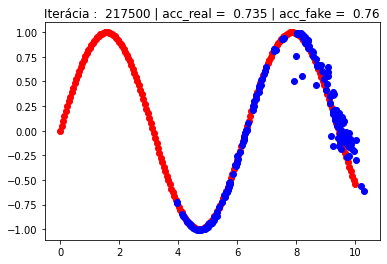

219999 0.6150000095367432 0.925000011920929


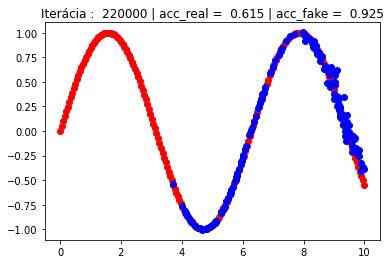

222499 0.6499999761581421 0.8999999761581421


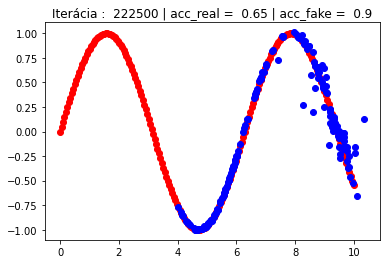

224999 0.6100000143051147 0.8550000190734863


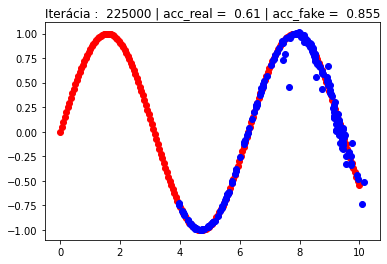

227499 0.6449999809265137 0.8700000047683716


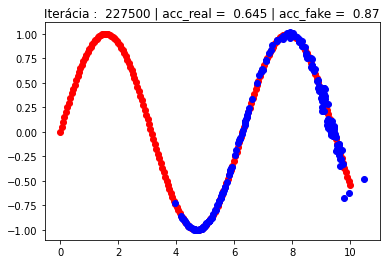

229999 0.6499999761581421 0.8500000238418579


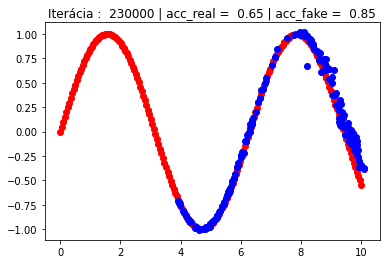

232499 0.625 0.8600000143051147


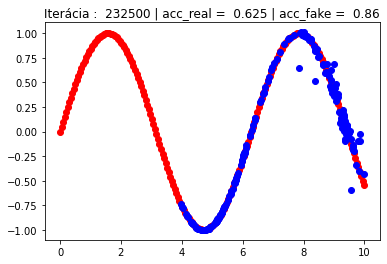

234999 0.5550000071525574 0.9100000262260437


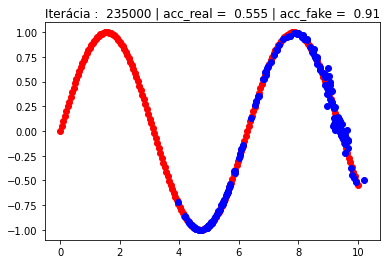

237499 0.6349999904632568 0.8450000286102295


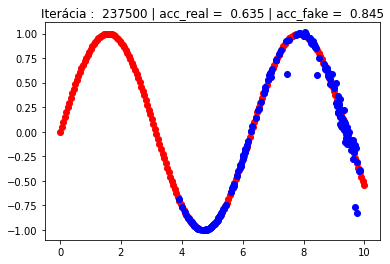

239999 0.6600000262260437 0.9300000071525574


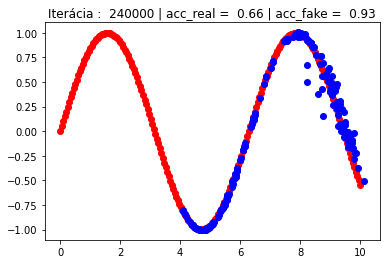

242499 0.574999988079071 0.824999988079071


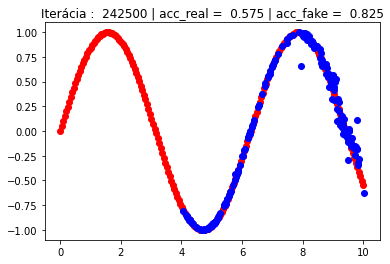

244999 0.6299999952316284 0.8199999928474426


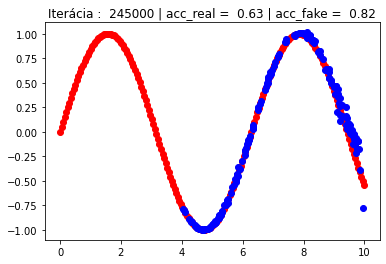

247499 0.7300000190734863 0.7300000190734863


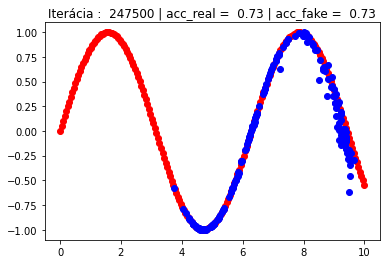

249999 0.6800000071525574 0.8349999785423279


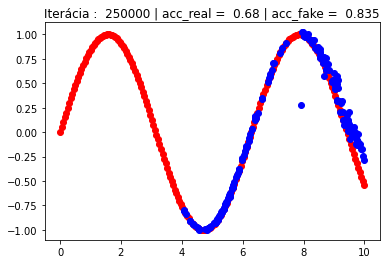

252499 0.6349999904632568 0.8600000143051147


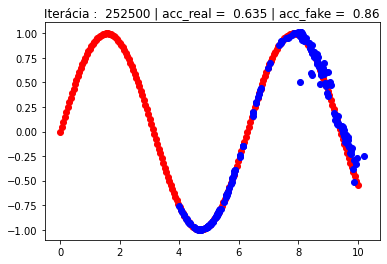

254999 0.6349999904632568 0.9399999976158142


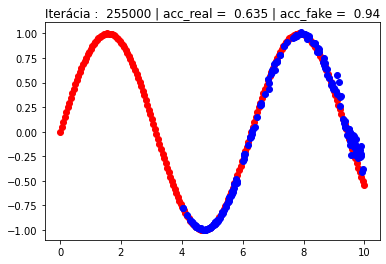

257499 0.625 0.8949999809265137


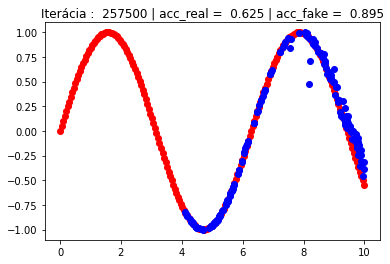

259999 0.6949999928474426 0.7599999904632568


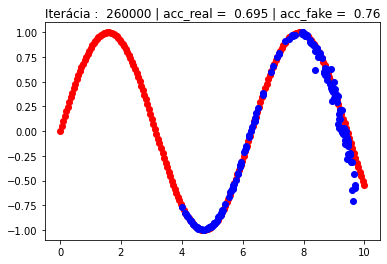

262499 0.625 0.9100000262260437


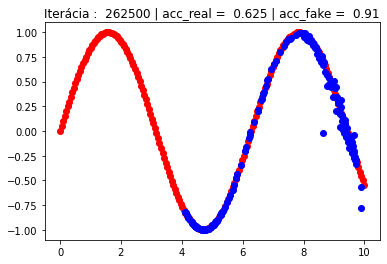

264999 0.6349999904632568 0.875


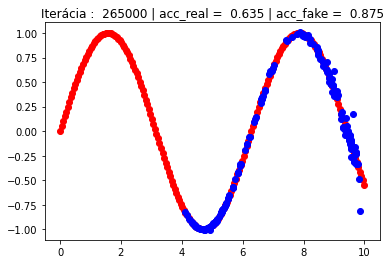

267499 0.6600000262260437 0.8949999809265137


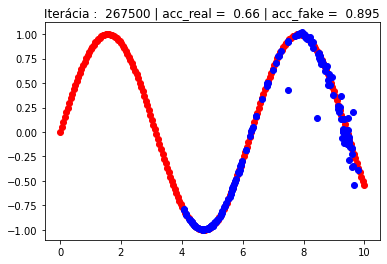

269999 0.6449999809265137 0.8999999761581421


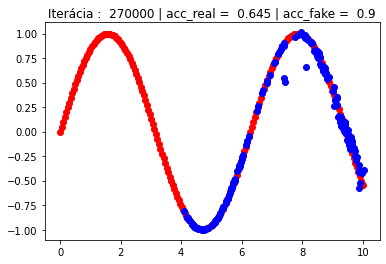

272499 0.6800000071525574 0.8500000238418579


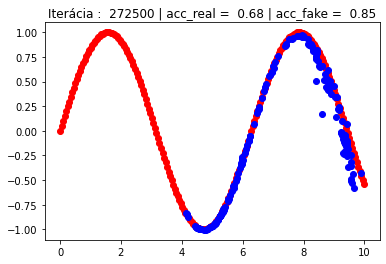

274999 0.6000000238418579 0.8650000095367432


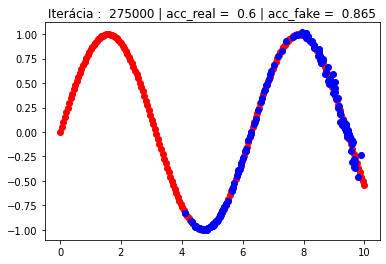

277499 0.6299999952316284 0.9200000166893005


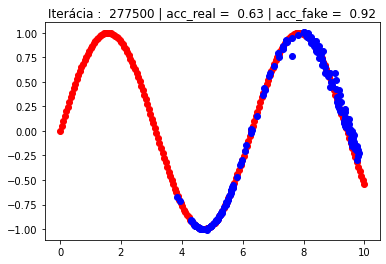

279999 0.6600000262260437 0.8949999809265137


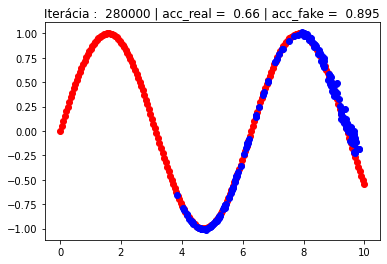

282499 0.5849999785423279 0.9300000071525574


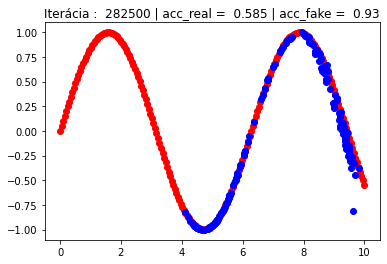

284999 0.675000011920929 0.8949999809265137


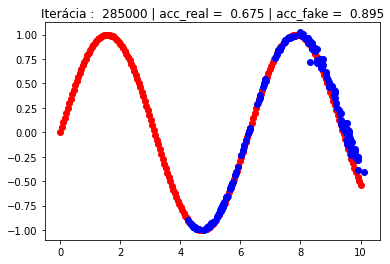

287499 0.6549999713897705 0.875


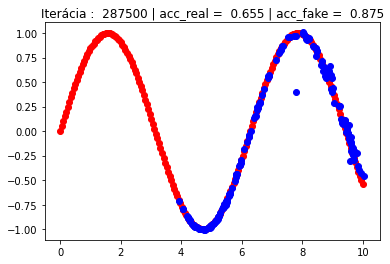

289999 0.6600000262260437 0.8450000286102295


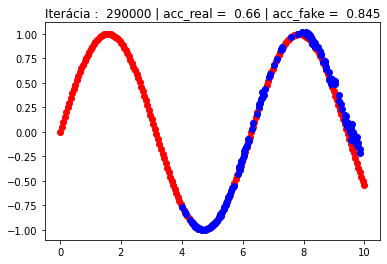

292499 0.6700000166893005 0.8399999737739563


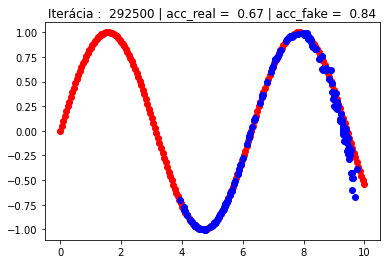

294999 0.7250000238418579 0.6800000071525574


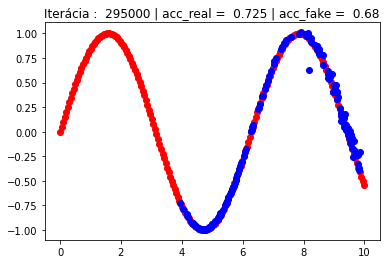

297499 0.6349999904632568 0.8899999856948853


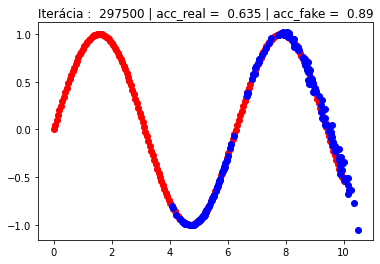

299999 0.6800000071525574 0.8600000143051147


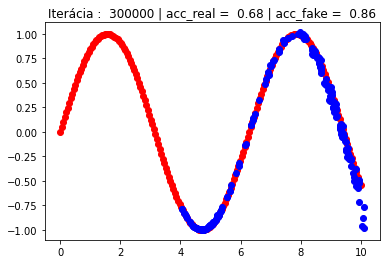

302499 0.5899999737739563 0.8500000238418579


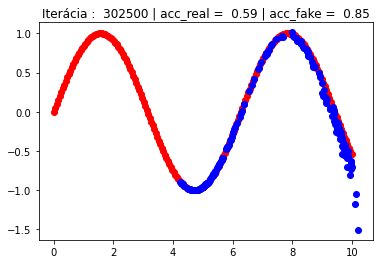

304999 0.6650000214576721 0.8650000095367432


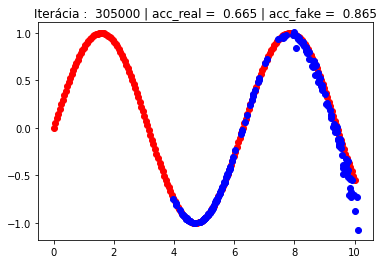

307499 0.6549999713897705 0.8899999856948853


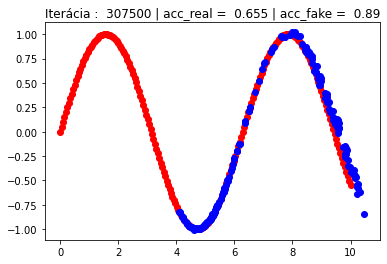

309999 0.7099999785423279 0.8799999952316284


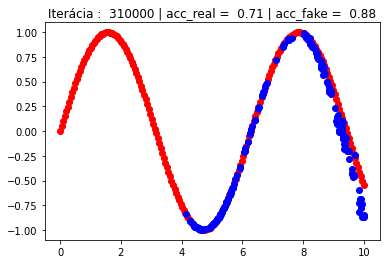

312499 0.6600000262260437 0.8899999856948853


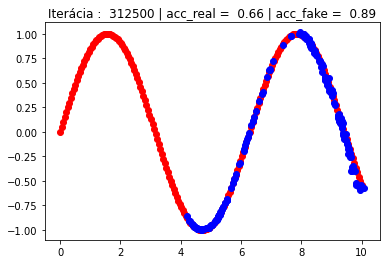

314999 0.7300000190734863 0.7099999785423279


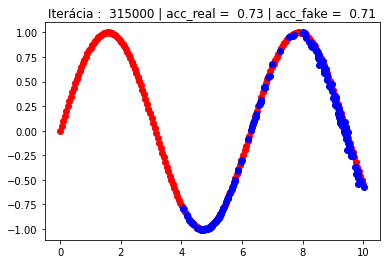

317499 0.7400000095367432 0.7699999809265137


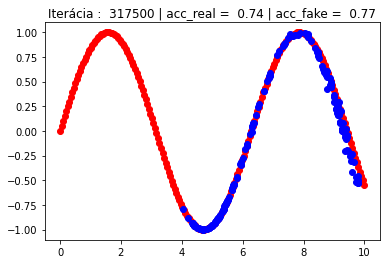

319999 0.6499999761581421 0.8650000095367432


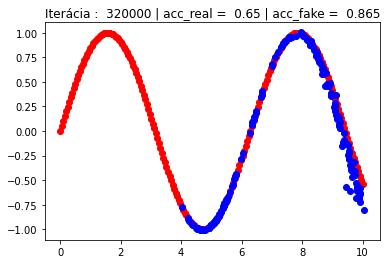

322499 0.6800000071525574 0.8650000095367432


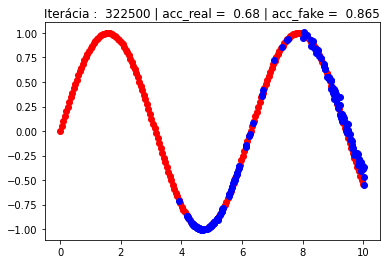

324999 0.7699999809265137 0.8949999809265137


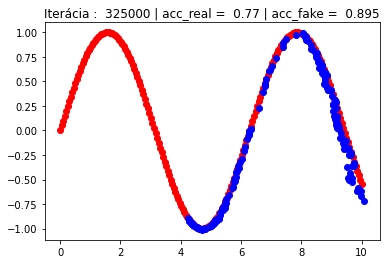

327499 0.7400000095367432 0.875


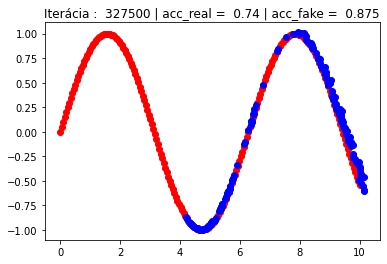

329999 0.7200000286102295 0.8949999809265137


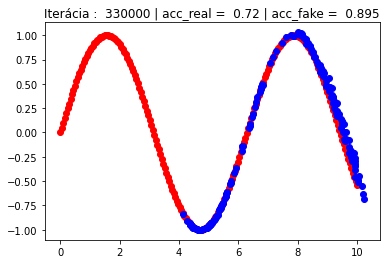

332499 0.699999988079071 0.8199999928474426


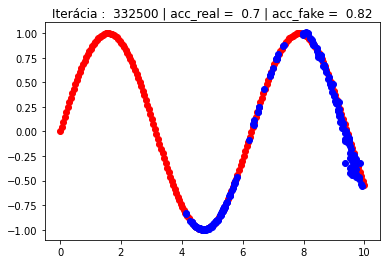

334999 0.6000000238418579 0.9399999976158142


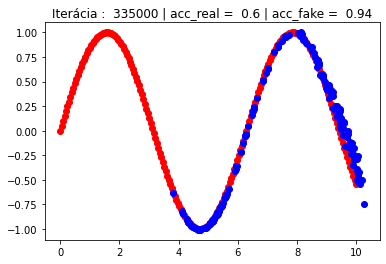

337499 0.7400000095367432 0.7850000262260437


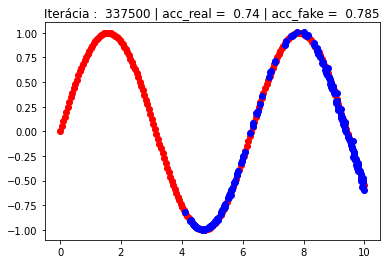

339999 0.6899999976158142 0.8849999904632568


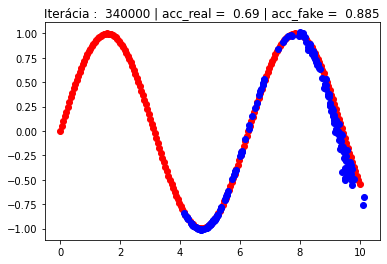

342499 0.7300000190734863 0.7699999809265137


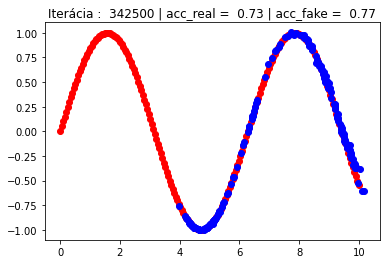

344999 0.7049999833106995 0.925000011920929


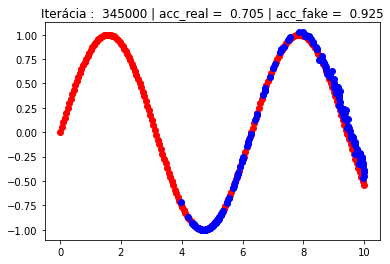

347499 0.7049999833106995 0.8450000286102295


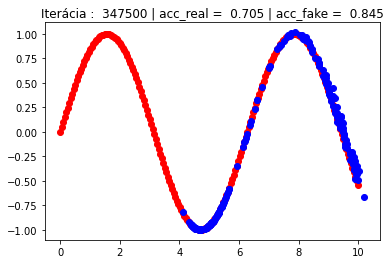

349999 0.6800000071525574 0.8149999976158142


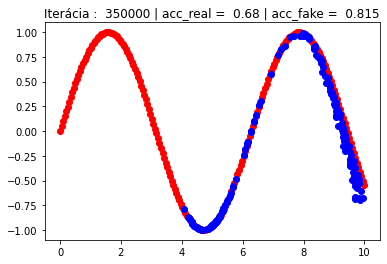

352499 0.6899999976158142 0.9449999928474426


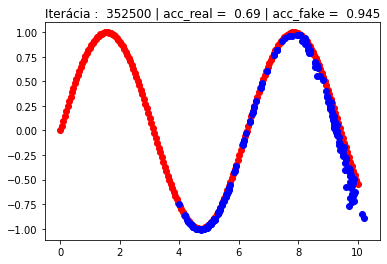

354999 0.7599999904632568 0.8149999976158142


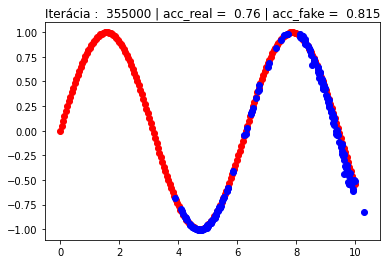

357499 0.6949999928474426 0.8999999761581421


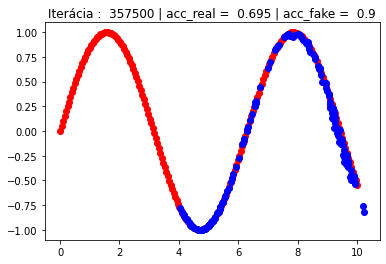

359999 0.6949999928474426 0.8500000238418579


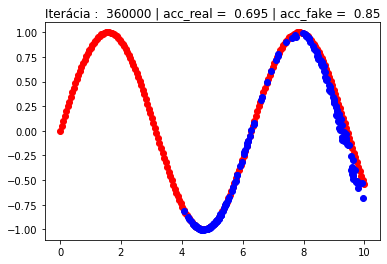

362499 0.7749999761581421 0.6150000095367432


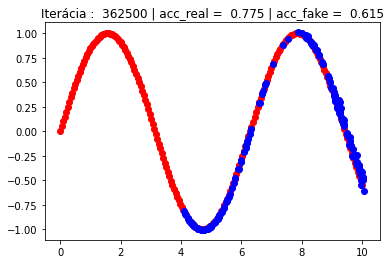

364999 0.7149999737739563 0.9049999713897705


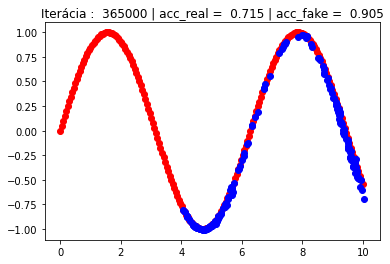

367499 0.6899999976158142 0.8500000238418579


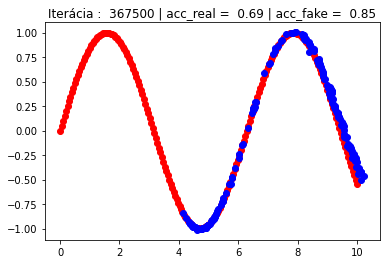

369999 0.6800000071525574 0.7549999952316284


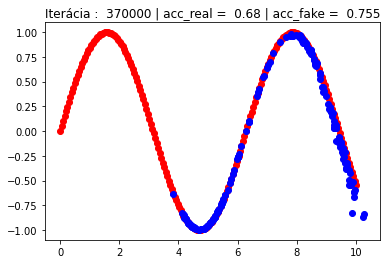

372499 0.6600000262260437 0.8849999904632568


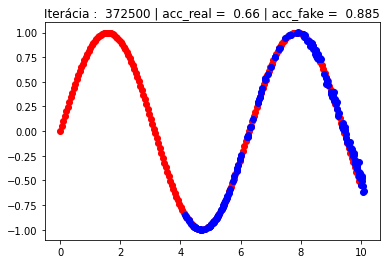

374999 0.675000011920929 0.8799999952316284


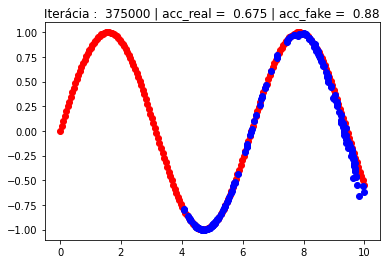

377499 0.75 0.824999988079071


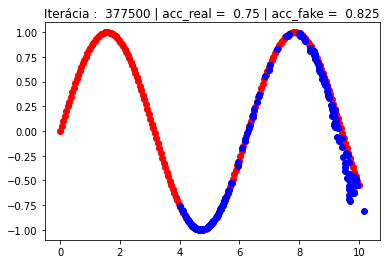

379999 0.7049999833106995 0.8650000095367432


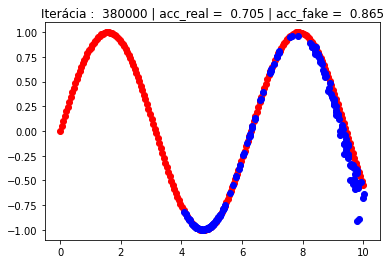

382499 0.7049999833106995 0.800000011920929


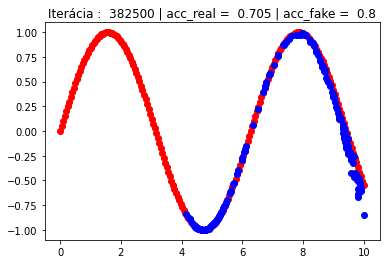

384999 0.75 0.9300000071525574


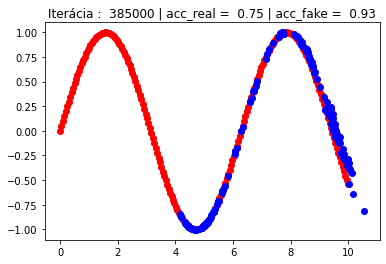

387499 0.7200000286102295 0.925000011920929


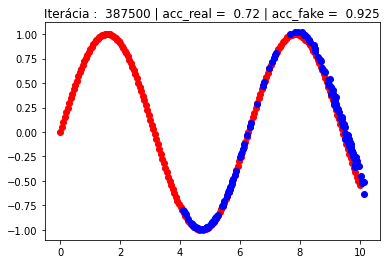

389999 0.6800000071525574 0.8999999761581421


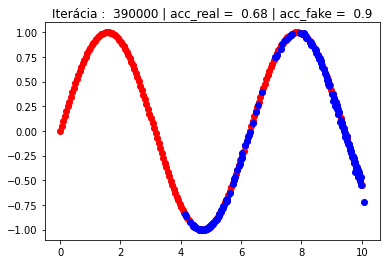

392499 0.6600000262260437 0.8799999952316284


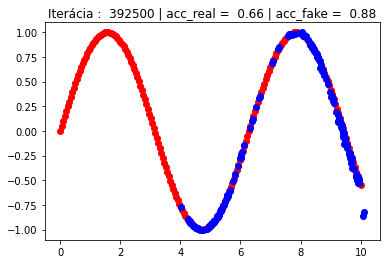

394999 0.6499999761581421 0.9049999713897705


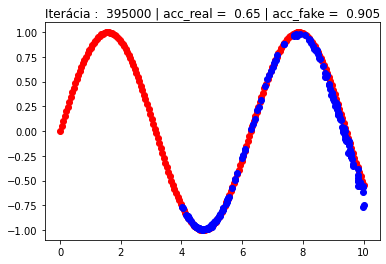

397499 0.6700000166893005 0.8999999761581421


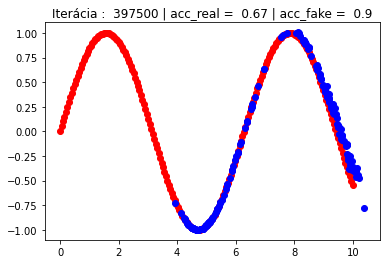

399999 0.6800000071525574 0.8600000143051147


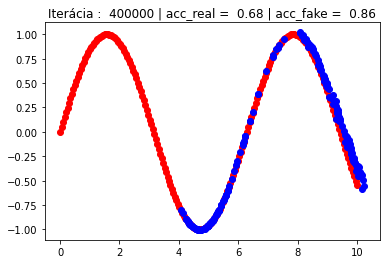

402499 0.5099999904632568 0.9449999928474426


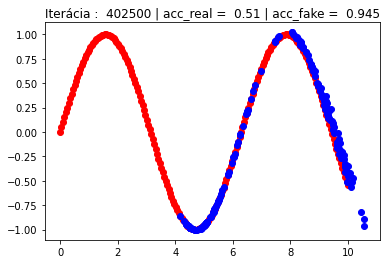

404999 0.7099999785423279 0.8899999856948853


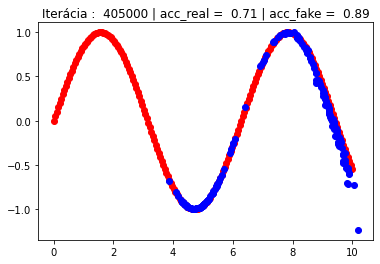

407499 0.7149999737739563 0.8500000238418579


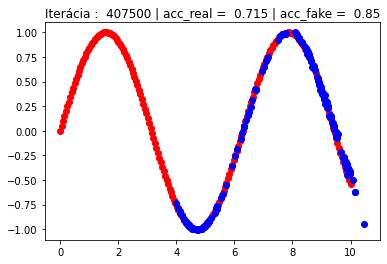

409999 0.6850000023841858 0.8100000023841858


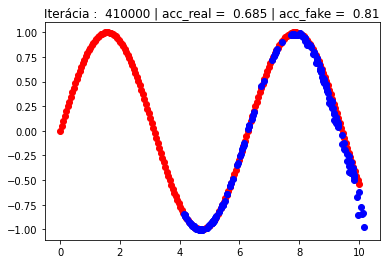

412499 0.7149999737739563 0.875


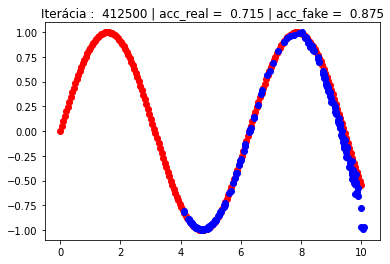

414999 0.6850000023841858 0.8100000023841858


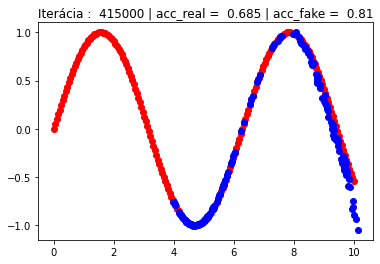

417499 0.6899999976158142 0.7950000166893005


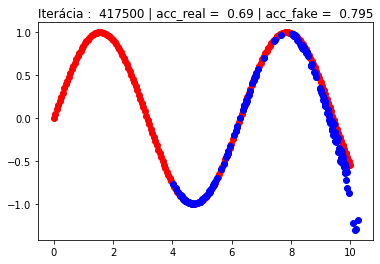

419999 0.6349999904632568 0.8849999904632568


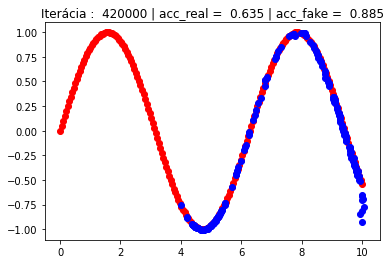

422499 0.7049999833106995 0.8199999928474426


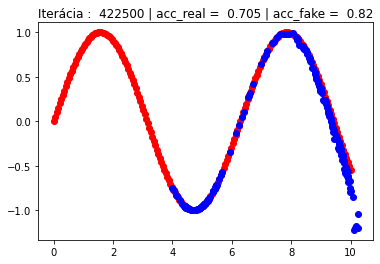

424999 0.6850000023841858 0.824999988079071


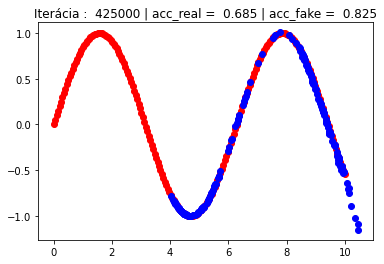

427499 0.7149999737739563 0.8450000286102295


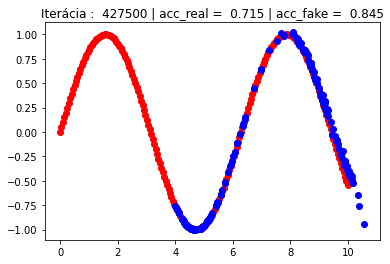

429999 0.7350000143051147 0.9049999713897705


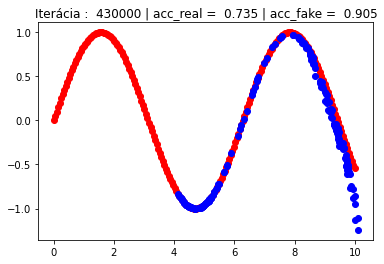

432499 0.7200000286102295 0.9449999928474426


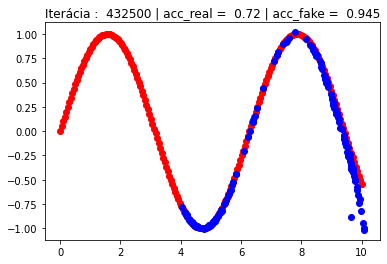

434999 0.7950000166893005 0.7950000166893005


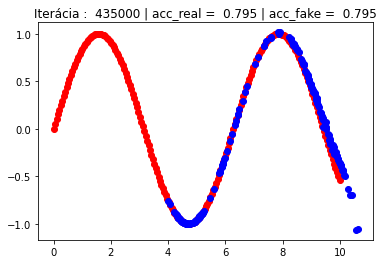

437499 0.7400000095367432 0.875


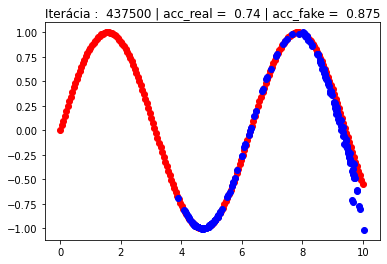

439999 0.7149999737739563 0.8199999928474426


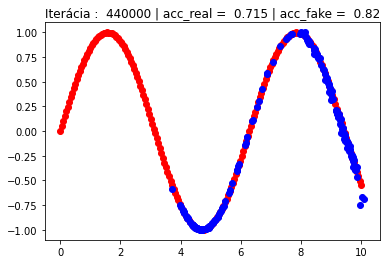

442499 0.6549999713897705 0.8799999952316284


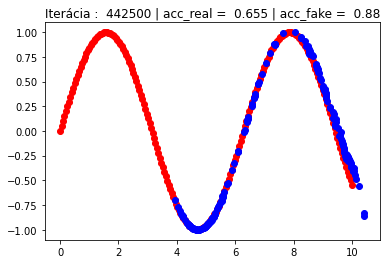

444999 0.7200000286102295 0.7749999761581421


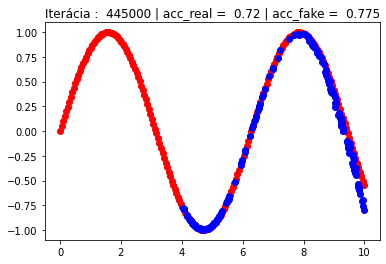

447499 0.7200000286102295 0.8500000238418579


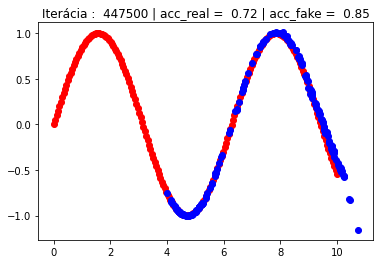

449999 0.7950000166893005 0.8899999856948853


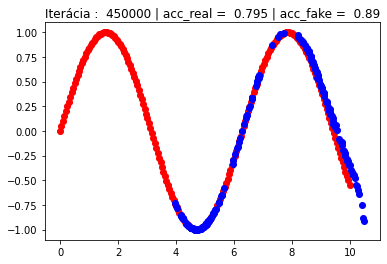

452499 0.675000011920929 0.8999999761581421


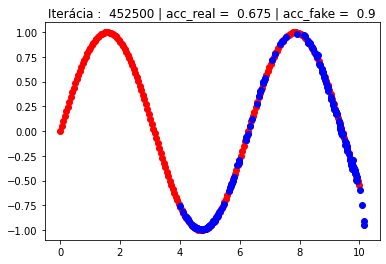

454999 0.7099999785423279 0.8349999785423279


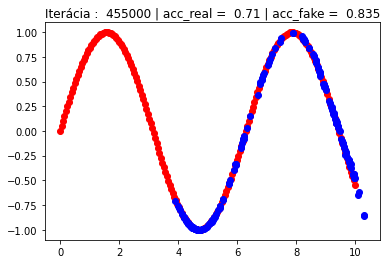

457499 0.6650000214576721 0.7900000214576721


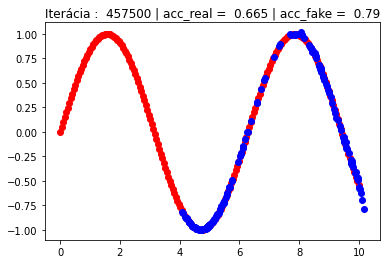

459999 0.7450000047683716 0.9150000214576721


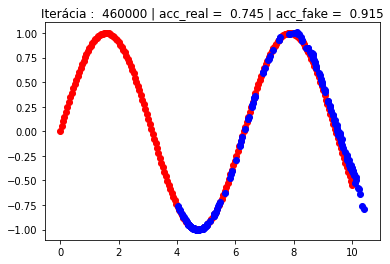

462499 0.7300000190734863 0.7950000166893005


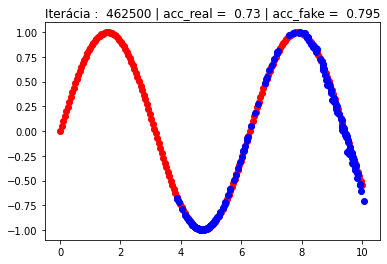

464999 0.5950000286102295 0.9800000190734863


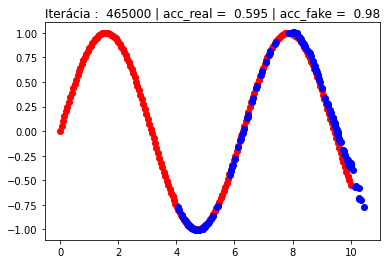

467499 0.7599999904632568 0.8149999976158142


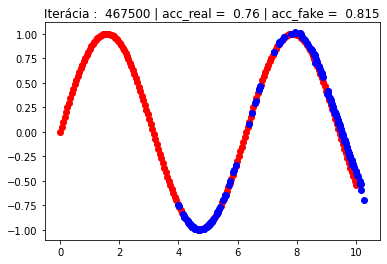

469999 0.6899999976158142 0.7950000166893005


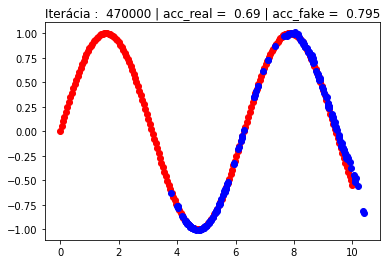

472499 0.7099999785423279 0.9200000166893005


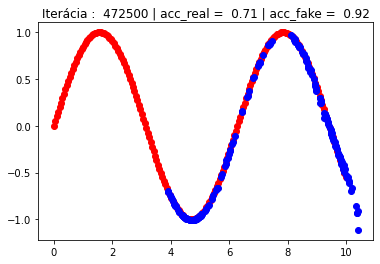

474999 0.7149999737739563 0.7599999904632568


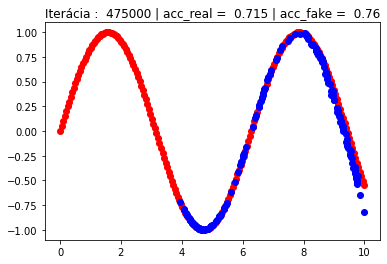

477499 0.7300000190734863 0.7099999785423279


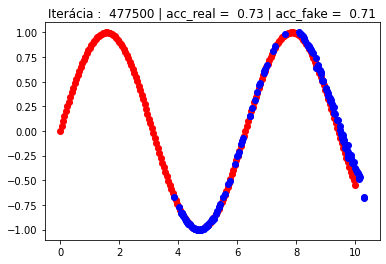

479999 0.6800000071525574 0.7200000286102295


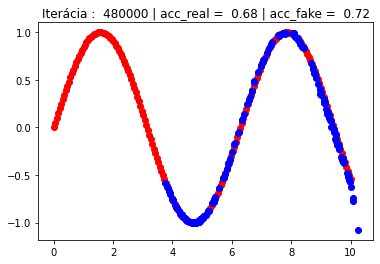

482499 0.7350000143051147 0.8700000047683716


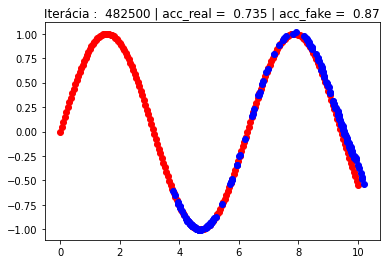

484999 0.7400000095367432 0.6549999713897705


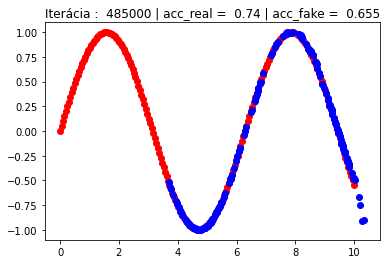

487499 0.7049999833106995 0.8999999761581421


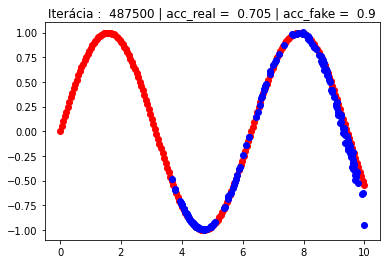

489999 0.7450000047683716 0.9200000166893005


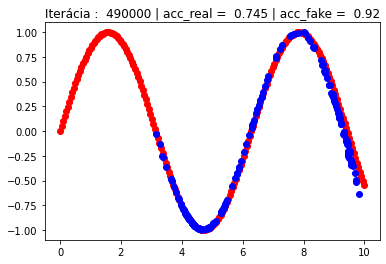

492499 0.7049999833106995 0.7549999952316284


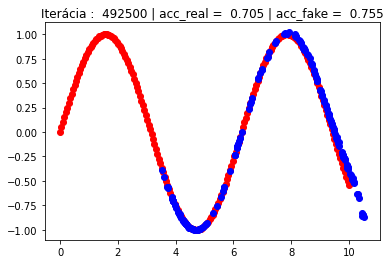

494999 0.7049999833106995 0.4650000035762787


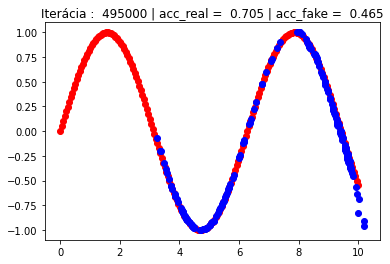

497499 0.75 0.7400000095367432


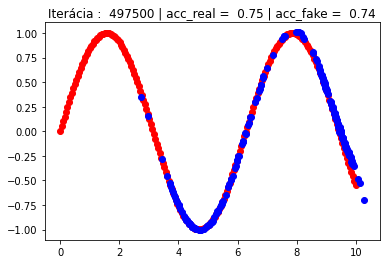

499999 0.6299999952316284 0.7699999809265137


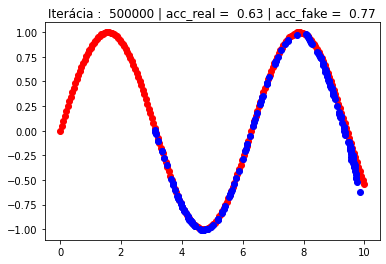

9926.161574279999


In [5]:
start = timer()

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [0,5000]
  X1 = np.linspace(0,10,n)
  # generate outputs 
  X2 = np.sin(X1)  #np.random.random(1)*
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=200):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	# plt.xlabel('x',fontsize=12)
	# plt.ylabel('y',fontsize=12)
	pyplot.title('Iterácia :'+ "  " + str(epoch+1)+" | "+'acc_real ='+"  "+str(np.round(acc_real,4))+" | "+'acc_fake ='+"  "+str(np.round(acc_fake,4)))
	pyplot.show()
	# if (acc_fake > 0.475) and (acc_fake < 0.525) and (acc_real > 0.475) and (acc_real < 0.525) and epoch>200000:
	# 	print('Model is trained')
	# 	a=1/0

def train(generator_model, discriminator_model, gan_model, latent_dim, n_epochs=500000, n_batch=512,n_eval=2500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch) # generator model instead of random numbers
		# update discriminator
		d_real_loss,d_real_acc=discriminator_model.train_on_batch(x_real, y_real)
		d_fake_loss,d_fake_acc=discriminator_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		g_loss=gan_model.train_on_batch(x_gan, y_gan)
		d_real_loss_graph2.append(d_real_loss)
		d_real_acc_graph2.append(d_real_acc)
		d_fake_loss_graph2.append(d_fake_loss)
		d_fake_acc_graph2.append(d_fake_acc)
		g_loss_graph2.append(g_loss)
  # evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
		  summarize_performance(i, generator_model, discriminator_model, latent_dim)

d_real_loss_graph2=[]
d_real_acc_graph2=[]
d_fake_loss_graph2=[]
d_fake_acc_graph2=[]
g_loss_graph2=[]
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator2 = define_discriminator()
# create the generator
generator2 = define_generator(latent_dim)
# create the gan
gan_model2 = define_gan(generator2, discriminator2)
# train model
train(generator2, discriminator2, gan_model2, latent_dim)


end = timer()
print(end - start) # 9926.161574279999 sekund = 165 minut


### Plotting losses and accuracies
SINUS

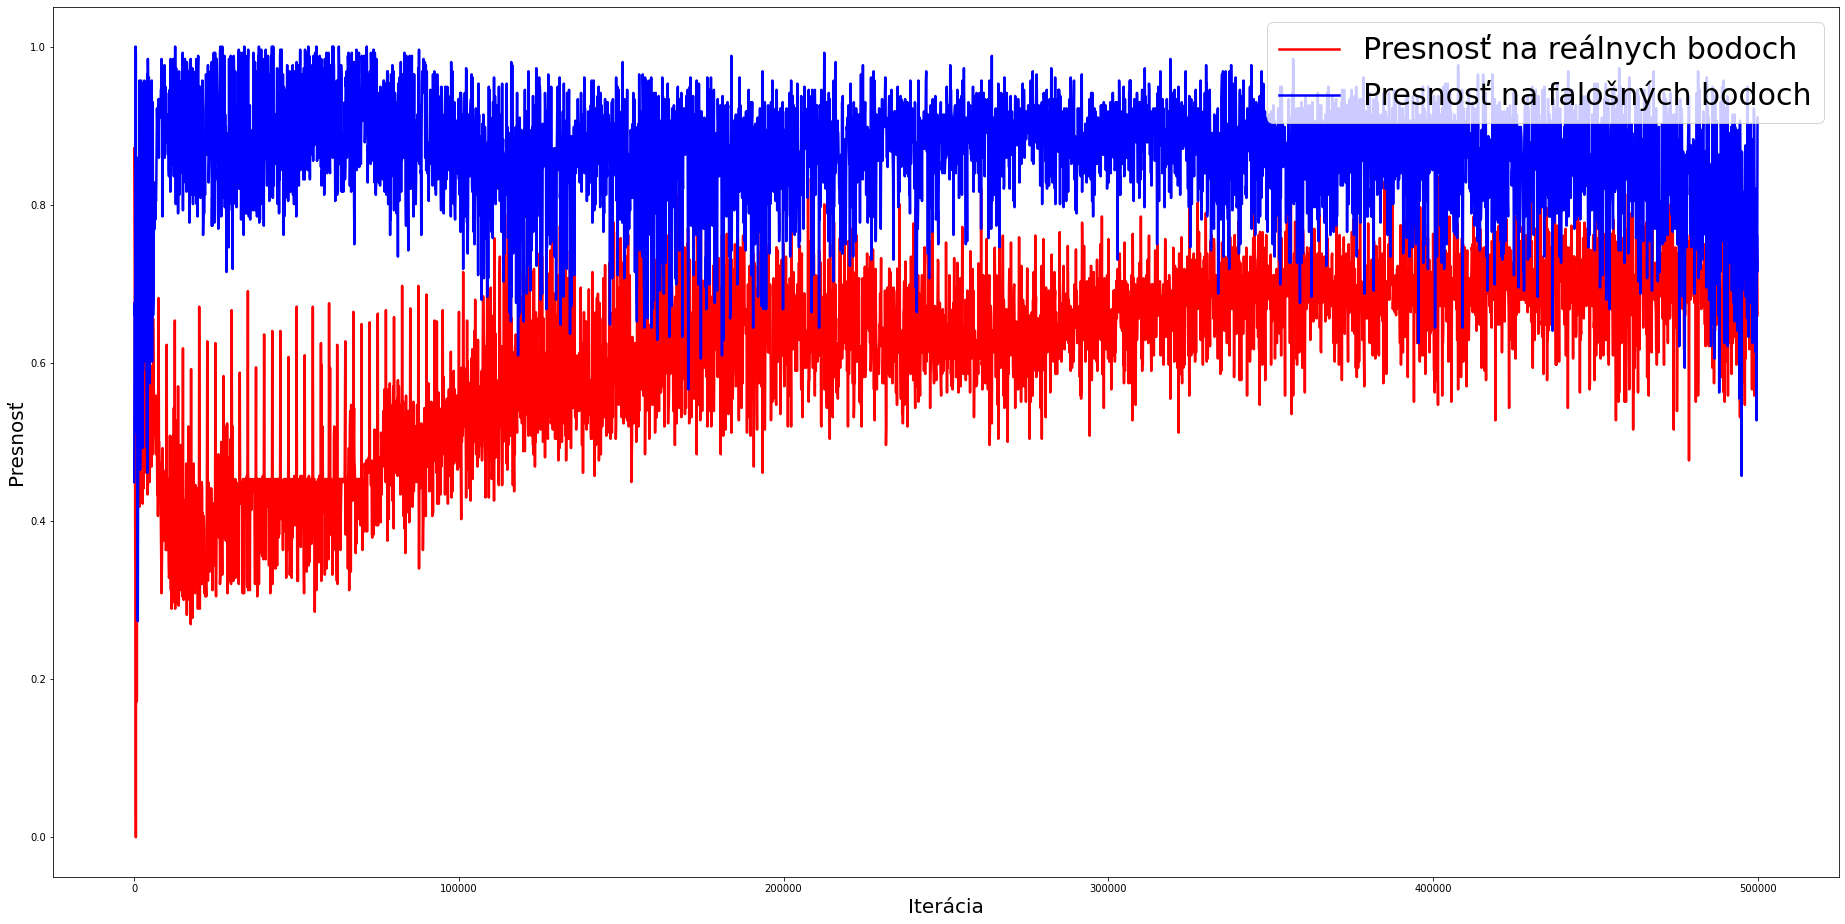

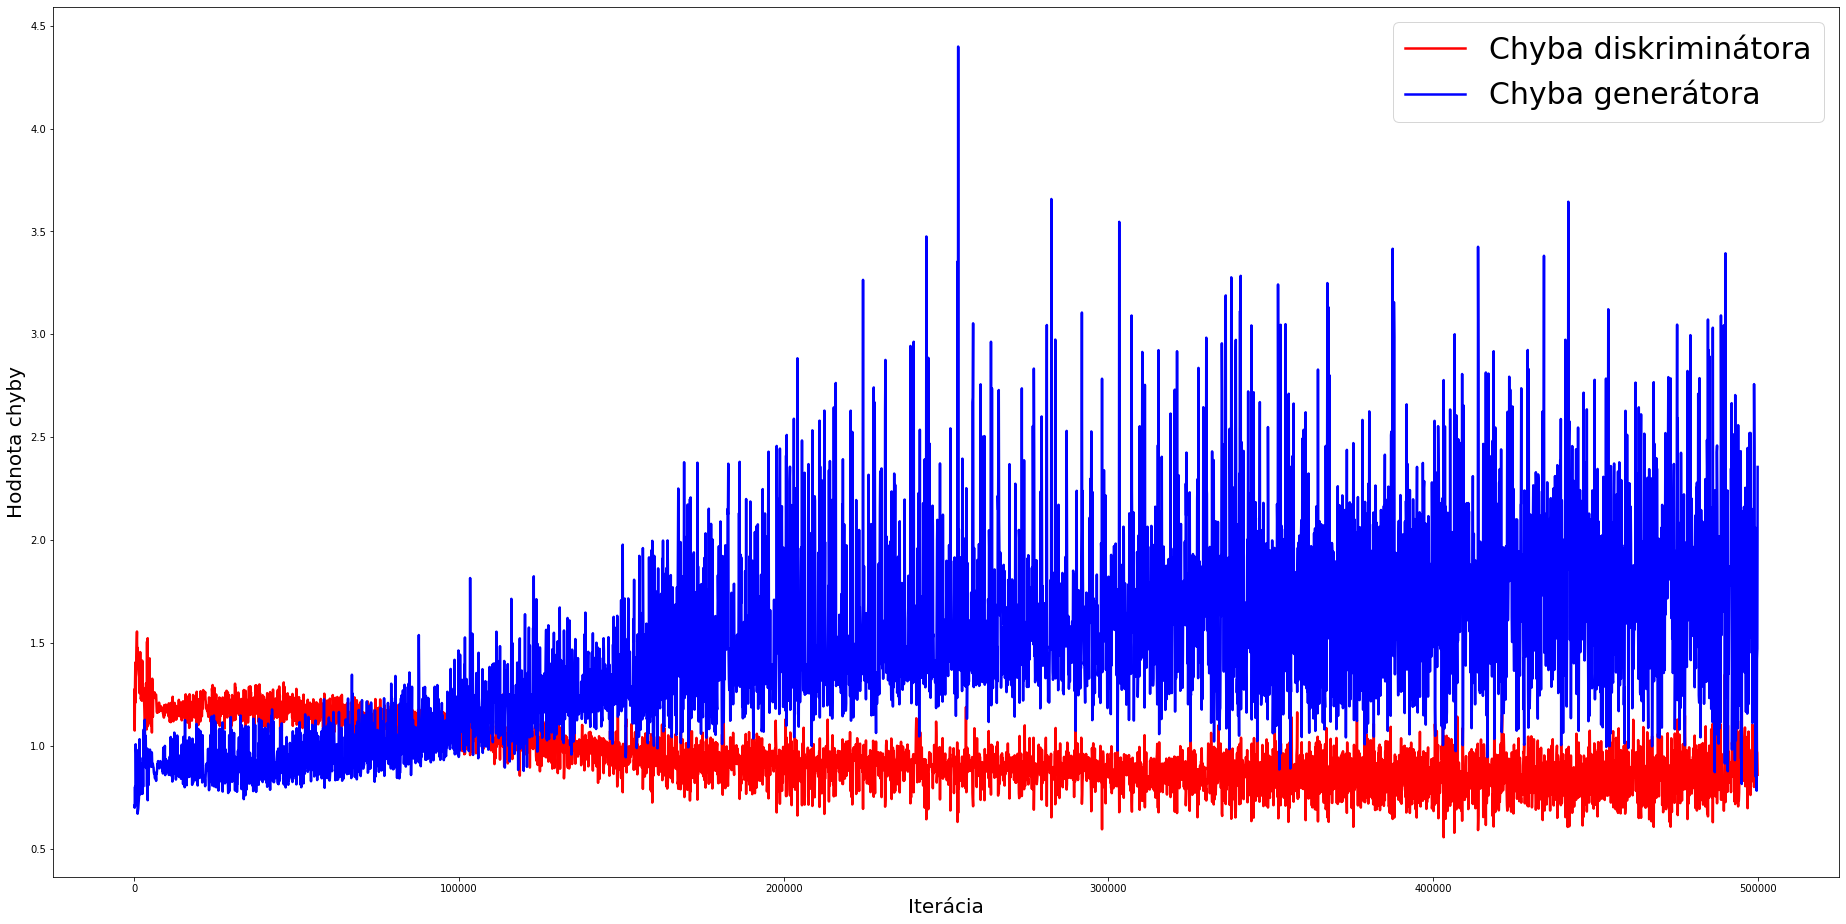

In [12]:
filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

time_axis=np.linspace(0,500000,5000)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť na reálnych bodoch', 'x': time_axis, 'y': filtered_acc_real2[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť na falošných bodoch', 'x': time_axis, 'y': filtered_acc_fake2[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Presnosť',fontsize=20)


time_axis=np.linspace(0,500000,5000)
d_loss_total2= np.array(d_real_loss_graph2)+np.array(d_fake_loss_graph2)

filtered_loss_real2 = [ item for i,item in enumerate(d_loss_total2) if i%100==0 ]
filtered_loss_fake2 = [ item for i,item in enumerate(g_loss_graph2) if i%100==0 ]

fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': filtered_loss_real2[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': filtered_loss_fake2[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Hodnota chyby',fontsize=20)

## **Testing generators**

### X^2

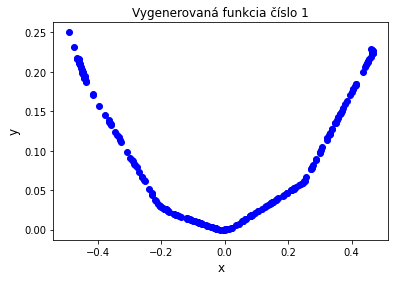

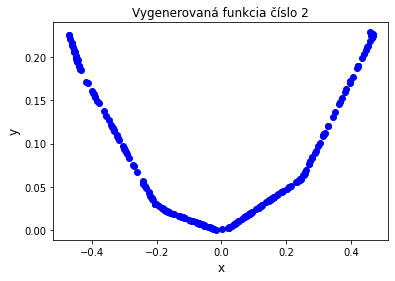

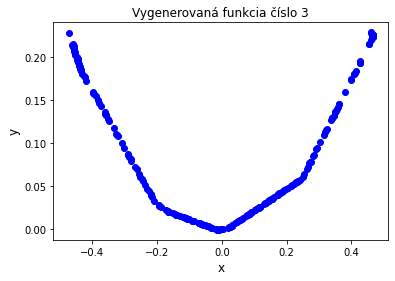

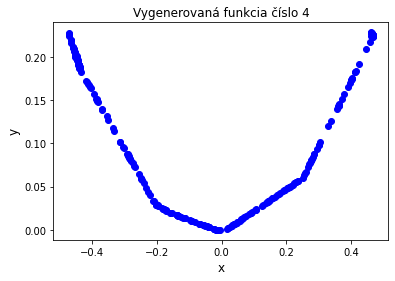

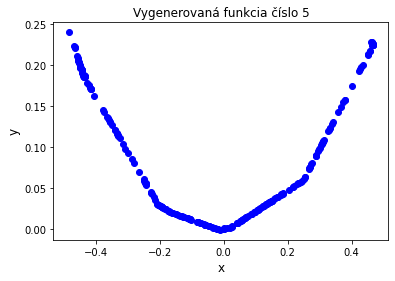

In [0]:
# X^2
for i in range(5): 
  x_fake=[]
  y_fake=[]
  x_fake, y_fake = generate_fake_samples(generator, 5, 250)
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.xlabel('x',fontsize=12)
  plt.ylabel('y',fontsize=12)
  plt.title('Vygenerovaná funkcia číslo'+' '+str(i+1))
  pyplot.show()

### SINUS

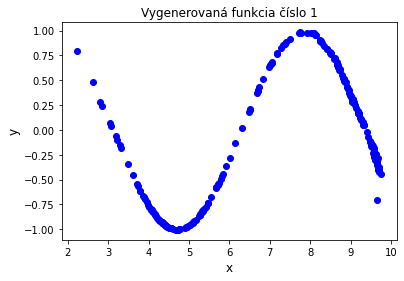

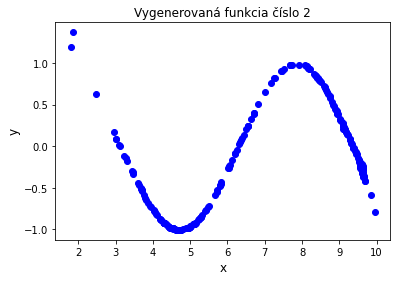

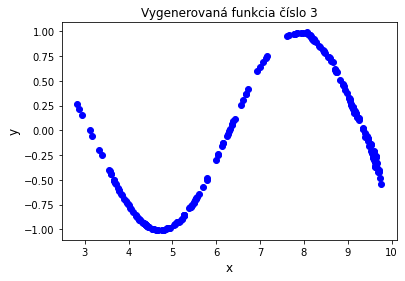

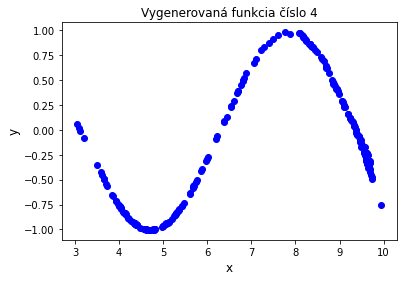

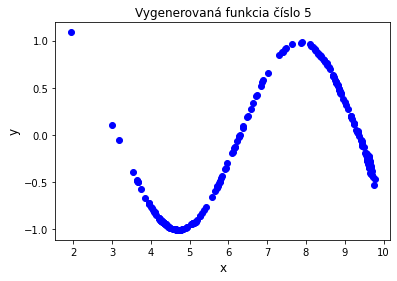

In [14]:
# SINUS
for i in range(5): 
  x_fake=[]
  y_fake=[]
  x_fake, y_fake = generate_fake_samples(generator2, 5, 250)
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.xlabel('x',fontsize=12)
  plt.ylabel('y',fontsize=12)
  plt.title('Vygenerovaná funkcia číslo'+' '+str(i+1))
  pyplot.show()